### Import lib

In [20]:
%load_ext lab_black

In [21]:
import os

os.chdir("/cerea_raid/users/dumontj/dev/coco2/dl")
import numpy as np
import sys
import pandas as pd
import xarray as xr
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib_functions

matplotlib_functions.setMatplotlibParam()
plt.viridis()
import joblib
import pickle
from include.generators import Generator
from saver import Saver
from include.callbacks import get_modelcheckpoint, ExtraValidation

import model_eval
from Data import Data_train, Data_eval
import wandb
from wandb.keras import WandbCallback, WandbMetricsLogger
import models.reg as rm
from include.loss import rmae

<Figure size 1920x1440 with 0 Axes>

### Data download

In [73]:
path_train_nc = "/libre/dumontj/coco2/dl-input/2km_forLip_2/train_dataset.nc"
path_valid_nc = "/libre/dumontj/coco2/dl-input/2km_forLip_2/valid_dataset.nc"
path_extra_valid_nc = "/libre/dumontj/coco2/dl-input/2km_Lip/valid_dataset.nc"
path_eval_nc = path_extra_valid_nc

save_dir = "/cerea_raid/users/dumontj/dev/coco2/dl/nb_train/sim/linear_cnn"

In [74]:
chan_1 = "xco2"
chan_2 = "seg_2km_64_lip_no2_2"
chan_3 = "no2"

In [75]:
data = Data_train(
    path_train_nc,
    path_valid_nc,
    path_extra_valid_nc,
)
data.prepare_input(chan_1, chan_2, chan_3)

data.prepare_output_inversion()

/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/layers/core/lambda_layer.py:324: UserWarning: models.Unet_backboned is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


393/393 [==============================] - 6s 14ms/step


/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/layers/core/lambda_layer.py:324: UserWarning: models.Unet_backboned is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


72/72 [==============================] - 2s 13ms/step


/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/layers/core/lambda_layer.py:324: UserWarning: models.Unet_backboned is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


36/36 [==============================] - 1s 12ms/step
data.x.train.shape (12576, 64, 64, 3)


### Generator

In [26]:
generator = Generator("inversion", 32, 45, 0.2, True, 45, 0.2, shuffle=True)

### Model def

In [32]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(16, (3, 3), input_shape=data.x.fields_input_shape))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(16, (3, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(16, (3, 3)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Dense(1))

model.compile("adam", loss="MeanAbsoluteError")

In [33]:
wandb.finish()

epoch/epoch,▁▅█
epoch/learning_rate,▁▁▁
epoch/loss,█▃▁
epoch/val_loss,█▁▆
extra_val_loss,█▂▁
epoch/epoch,2
epoch/learning_rate,0.001
epoch/loss,2.39358
epoch/val_loss,2.50437
extra_val_loss,4.27004


In [34]:
exp_name = "linear"
project_name = "test"
wandb.init(project=project_name, name=exp_name)

In [35]:
cbs = get_modelcheckpoint(True, [], os.path.join(save_dir, exp_name, "w_best.h5"))
history = ExtraValidation((data.x.extra_valid, data.y.extra_valid))
cbs.append(WandbMetricsLogger())
cbs.append(history)

### Train

In [76]:
model.fit(
    generator.flow(data.x.train, data.y.train),
    epochs=2000,
    validation_data=(data.x.valid, data.y.valid),
    callbacks=cbs,
    verbose=1,
)

Epoch 1/2000
393/393 [==============================] - ETA: 0s - loss: 2.6366
Epoch 1: val_loss did not improve from 2.49618
extra_val_loss: 3.8553590774536133
393/393 [==============================] - 16s 38ms/step - loss: 2.6366 - val_loss: 3.1363
Epoch 2/2000
393/393 [==============================] - ETA: 0s - loss: 2.6571
Epoch 2: val_loss did not improve from 2.49618
extra_val_loss: 2.797327756881714
393/393 [==============================] - 16s 40ms/step - loss: 2.6571 - val_loss: 4.0928
Epoch 3/2000
393/393 [==============================] - ETA: 0s - loss: 2.6292
Epoch 3: val_loss did not improve from 2.49618
extra_val_loss: 4.5785722732543945
393/393 [==============================] - 16s 42ms/step - loss: 2.6292 - val_loss: 2.6074
Epoch 4/2000
393/393 [==============================] - ETA: 0s - loss: 2.6326
Epoch 4: val_loss did not improve from 2.49618
extra_val_loss: 3.758143424987793
393/393 [==============================] - 16s 41ms/step - loss: 2.6326 - val_loss: 2

In [38]:
model.save(os.path.join(save_dir, "last_w.h5"))
joblib.dump(data.x.scaler, os.path.join(save_dir, "scaler.save"))

['/cerea_raid/users/dumontj/dev/coco2/dl/nb_train/sim/linear_cnn/scaler.save']

## Evaluation

In [77]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 29, 29, 16)        2320      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 12, 16)        2320      
                                                                 
 flatten_3 (Flatten)         (None, 2304)             

In [48]:
path_eval_nc = "/libre/dumontj/coco2/dl-input/2km_Lip/valid_dataset.nc"

In [57]:
data = Data_eval(path_eval_nc)
data.prepare_input(model_eval.get_scaler(save_dir), chan_1, chan_2, chan_3)
data.prepare_output_inversion()
model = model_eval.get_inversion_model(os.path.join(save_dir), name_w="last.h5")

/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/layers/core/lambda_layer.py:324: UserWarning: models.Unet_backboned is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


36/36 [==============================] - 2s 15ms/step
data.x.eval.shape (1152, 64, 64, 3)


In [58]:
metrics = model_eval.get_inv_metrics_model_on_data(model, data)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

36/36 [==============================] - 0s 2ms/step
mae: 3.8950467
mape: 24.033699


In [59]:
mean_metrics = model_eval.get_inv_mean_loss(data)
print("mae:", np.mean(mean_metrics["mae"]))
print("mape:", np.mean(mean_metrics["mape"]))

mae: 2.8285277
mape: 20.29815


36/36 [==============================] - 0s 3ms/step


<Figure size 1920x1440 with 0 Axes>

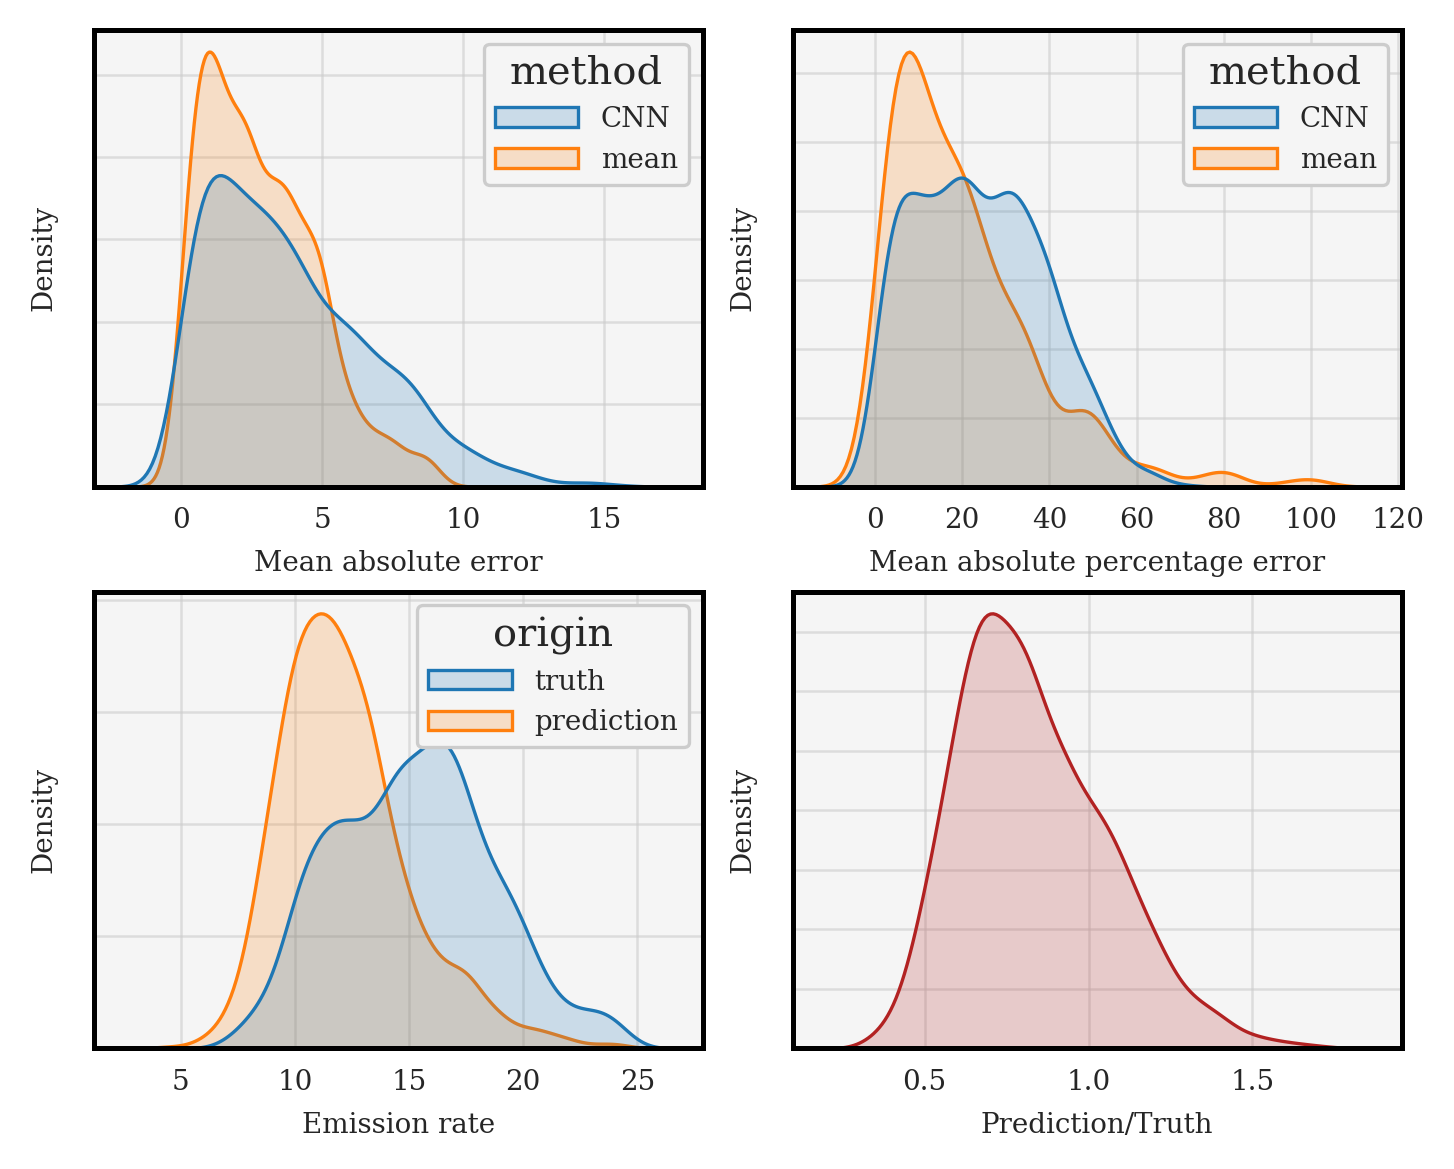

In [69]:
model_eval.get_summary_histo_inversion(model, data, dir_save=os.path.join(save_dir))

nwbce: tf.Tensor(1.6079993, shape=(), dtype=float32)
idx 749
origin: smart_2km_Lip_64
time: 2015-08-22T05:00:00.000000000
emiss: [9.607728 8.525012 8.644754]
nwbce: tf.Tensor(12.393336, shape=(), dtype=float32)
idx 37
origin: smart_2km_Lip_64
time: 2015-01-07T13:00:00.000000000
emiss: [22.72907 23.91462 24.11241]
nwbce: tf.Tensor(6.8493567, shape=(), dtype=float32)
idx 81
origin: smart_2km_Lip_64
time: 2015-01-22T09:00:00.000000000
emiss: [24.11241 21.34659 15.81191]
1/1 [==============================] - 0s 15ms/step


<Figure size 1920x1440 with 0 Axes>

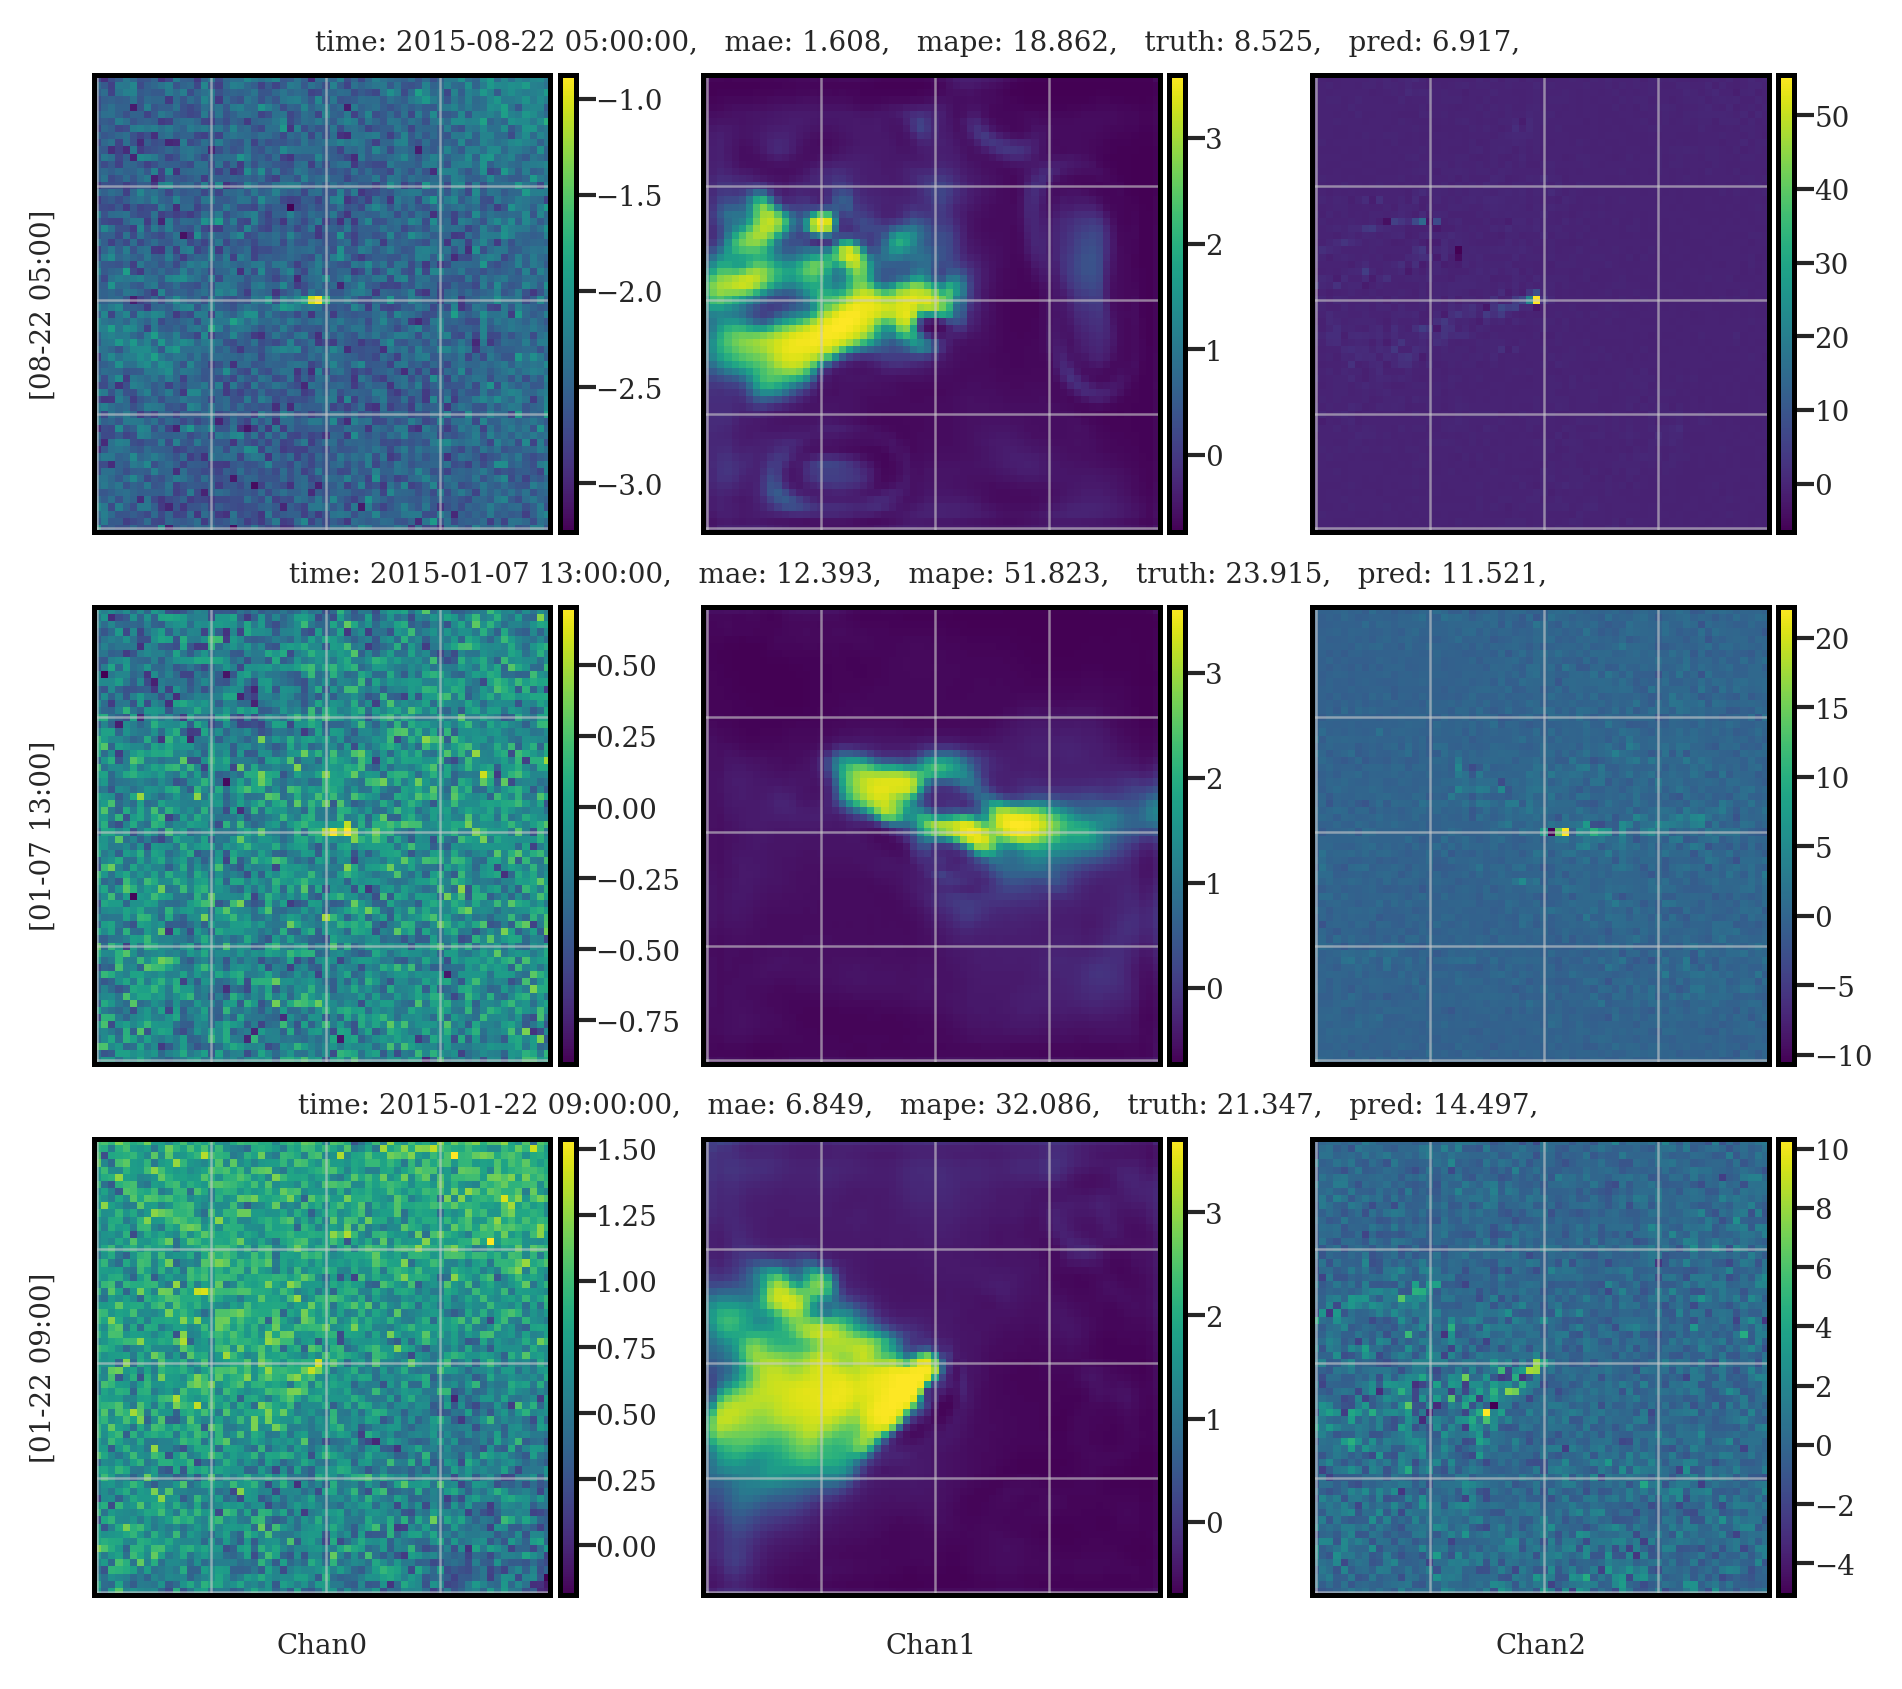

In [61]:
model_eval.plot_inversion_examples(data, metrics["mae"], metrics["mape"], model)